# Project Part 2
In this part of the project we will build a base model using RandomForestClassifier. We will be using a hate speech dataset of 1000 observations that are evenly distributed between toxic and not toxic.

In [1]:
import pandas as pd
import numpy as np

x = 'Text'
y = 'IsToxic'
df = pd.read_csv("youtoxic_english_1000.csv")
print(f"df.shape: {df.shape}")
df[[x,y]].head(10)

df.shape: (1000, 15)


,Text,IsToxic
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False
5,here people his facebook is https://www.facebo...,True
6,"Check out this you tube post. ""Black man goes ...",True
7,I would LOVE to see this pussy go to Staten Is...,True
8,I agree with the protestor.,False
9,mike browns father was made to say that boooshit,True


The dataset is pretty evenelly distributed, as shown below, between true and false in the IsToxic category. 

In [2]:
df.IsToxic.value_counts(normalize=True)

False    0.538
True     0.462
Name: IsToxic, dtype: float64

### Data Cleaning
The code below will clean our data before we vectorize it and use it for our training and validation.

In [3]:
from textblob import TextBlob, Word, Blobber
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Converting data set to String type
df['Text'] = df['Text'].astype(str)
df = df[~df["Text"].isnull()]

# Converting to lower case
df['cleanText'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing Stopwords
stop = stopwords.words('english')
df['cleanText'] = df['cleanText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Correcting any spelling mistake in the dataset
df['cleanText'].apply(lambda x: str(TextBlob(x).correct()))

# Stemming words in the dataset
st = PorterStemmer()
df['cleanText'] = df['cleanText'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

# Removing punctiation
df['cleanText'] = df['cleanText'].str.replace('[^\w\s]', '')
df[['cleanText', 'IsToxic']].head(10)

/var/folders/zc/w3_gp3bj2r75g6hkvhz1zd4w0000gn/T/ipykernel_30498/2262289315.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleanText'] = df['cleanText'].str.replace('[^\w\s]', '')


,cleanText,IsToxic
0,peopl would take step back make case them anyo...,False
1,law enforc train shoot apprehend train shoot k...,True
2,dont reckon black live matter banner held whit...,True
3,larg number peopl like polic officers call cri...,False
4,arab dude absolut right shot 6 extra time shoo...,False
5,peopl facebook httpswwwfacebookcombassemmasri5...,True
6,check tube post black man goe epic rant fergus...,True
7,would love see pussi go staten island spit cop...,True
8,agre protestor,False
9,mike brown father made say boooshit,True


### Split data into train and validations sets.
Now that our data is clean we will split our dataset into our train, validation, and test subsets.
We will be using 80% of our data for the training set, and 10% for the validation and test sets.

In [4]:
from sklearn.model_selection import train_test_split

cleanText = df['cleanText'].copy()
isToxic = df['IsToxic'].copy()

text_train, text_remaining, is_toxic_train, is_toxic_remaining = train_test_split(cleanText, isToxic, train_size=0.8)

text_val, text_test, is_toxic_val, is_toxic_test = train_test_split(text_remaining,is_toxic_remaining,test_size=0.5)

print(text_train.shape),print(is_toxic_train.shape)
print(text_val.shape),print(is_toxic_val.shape)
print(text_test.shape),print(is_toxic_test.shape)

(800,)
(800,)
(100,)
(100,)
(100,)
(100,)


(None, None)

#### Vectorization of Data

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

text_train_vect = tfidf_vectorizer.fit_transform(text_train).toarray()
print(f"text_train.shape = { text_train_vect.shape}")

text_train.shape = (800, 3657)


#### Decision Tree
We will fit our model using a RandomForestClassifier with n_estimators of 50.
Later we will tune our model and find the best hyperparameters for our model that will yield the best accuracy.

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50)
model = model.fit(text_train_vect, is_toxic_train)

predictions_train = model.predict(text_train_vect)

#### Display
Below we see that after our model is trained we receive an accuracy of 100%. This makes me think that 1000 observations is easy to train and might need a bigger dataset.

accuracy (on X_train): 1.0000


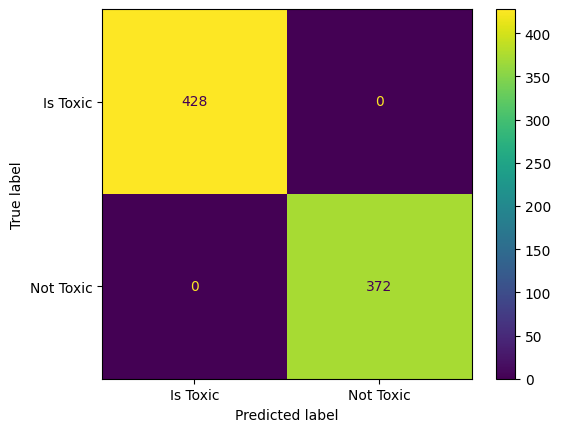

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

display = ConfusionMatrixDisplay(confusion_matrix(is_toxic_train, predictions_train),
display_labels=['Is Toxic', 'Not Toxic'])
display.plot()
print(f"accuracy (on X_train): {accuracy_score(is_toxic_train,predictions_train):.4f}")

### Validation 
Below we are validating our model with our validation dataset. The accuracy on our model is above 70% everytime is run. The model is having a hard time classifying Not Toxic labels as true Not Toxic labels.  

accuracy (on X_train): 0.7300


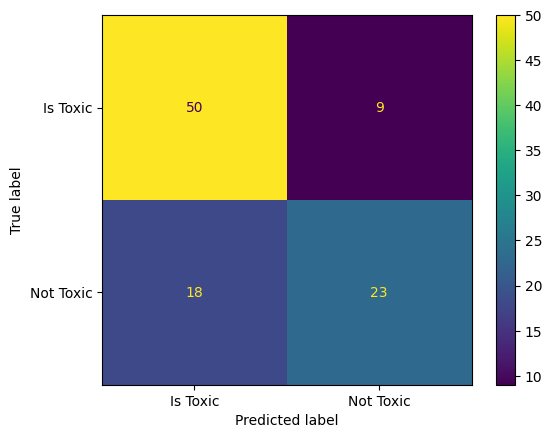

In [8]:
text_val_vect = tfidf_vectorizer.transform(text_val).toarray()
predictions_val = model.predict(text_val_vect)
disp = ConfusionMatrixDisplay(confusion_matrix(is_toxic_val, predictions_val), display_labels=['Is Toxic', 'Not Toxic'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(is_toxic_val, predictions_val):.4f}")

The function tuneModel will be used to tune our model by using different hyperparameter values 
for n_estimators and min_samples_split. The loss_and_accuracy_plot function will plot our results
from the tuneModel function. These two functions will be used in the next code segments.

In [9]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

def tuneModel(hp_value,param):
    if param == 'min_samples_split':
        rf_model = RandomForestClassifier(min_samples_split=hp_value)
    else:
        rf_model = RandomForestClassifier(n_estimators=hp_value)
    rf_model.fit(text_train_vect, is_toxic_train)
    is_toxic_train_pred_prob = rf_model.predict_proba(text_train_vect)
    is_toxic_train_pred = rf_model.predict(text_train_vect)
    is_toxic_val_pred_prob = rf_model.predict_proba(text_val_vect)
    is_toxic_val_pred = rf_model.predict(text_val_vect)
    train_loss = log_loss(is_toxic_train, is_toxic_train_pred_prob,labels=['Is Toxic', 'Not Toxic'])
    train_acc = accuracy_score(is_toxic_train,is_toxic_train_pred)
    val_loss = log_loss(is_toxic_val,is_toxic_val_pred_prob,labels=['Is Toxic', 'Not Toxic'])
    val_acc = accuracy_score(is_toxic_val, is_toxic_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

def loss_and_accuracy_plot(metrics, hyp_param_vals,x_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel=x_label, ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel=x_label, ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

### Tuning n_estimators
After running the code below, we get a display of the loss and accuracy of different n_estimators.
We can see that the best accuracy score is when n_estimators is equal to 160.
We can use this value for our final fit.

/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/pyt

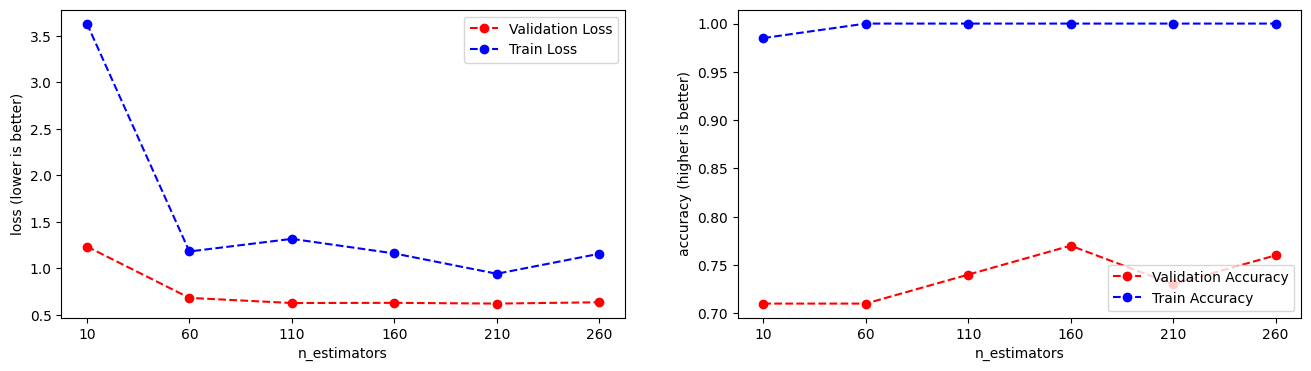

In [10]:
# n_estimators
n_hyp_param_values = list(range(10,261,50))
metrics = []

for hp in n_hyp_param_values:
    metrics.append(tuneModel(hp,'n_estimators'))

loss_and_accuracy_plot(metrics, n_hyp_param_values,"n_estimators")

In [11]:
tuning_results = np.array([n_hyp_param_values, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
print(tuning_results)

[[ 10.    60.   110.   160.   210.   260.  ]
 [  1.23   0.68   0.62   0.63   0.62   0.63]
 [  0.71   0.71   0.74   0.77   0.73   0.76]]


### Tuning min_samples_split
Just like n_estimators, we run different values through the tuneModel function to find what would be the best value for min_samples_split. We see that there is a higher accuracy when we use 5 as the min_samples_split.

/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/pyt

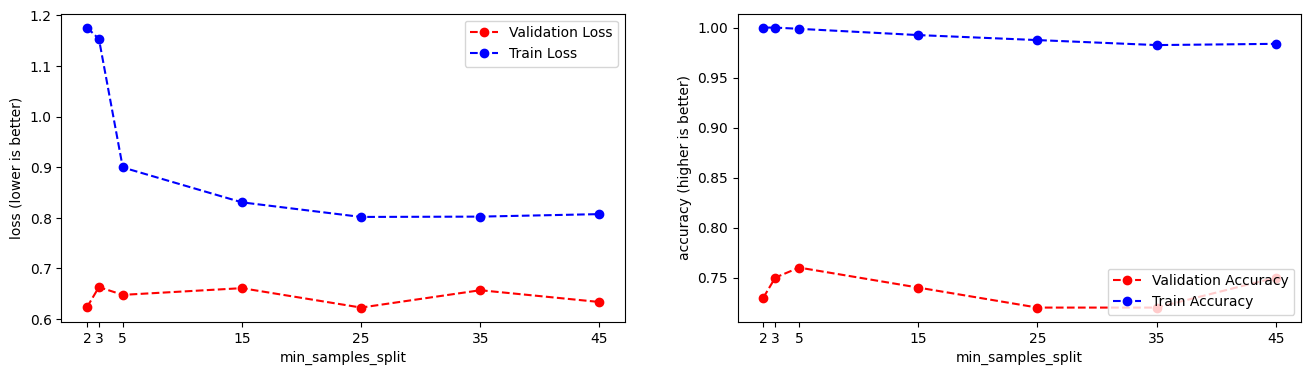

In [14]:
# min_samples_split 
split_hyp_param_values = [2,3] +list(range(5,50,10))
splitsMetrics = []

for hp in split_hyp_param_values:
    splitsMetrics.append(tuneModel(hp,'min_samples_split'))

loss_and_accuracy_plot(splitsMetrics, split_hyp_param_values,"min_samples_split")

In [15]:
# first row containing hyperparam values, second row containing validation loss, third row containing validation accuracy

tuning_results = np.array([split_hyp_param_values, [round(metric[1],2) for metric in splitsMetrics], [round(metric[3],2) for metric in splitsMetrics]])
print(tuning_results)

[[ 2.    3.    5.   15.   25.   35.   45.  ]
 [ 0.62  0.66  0.65  0.66  0.62  0.66  0.63]
 [ 0.73  0.75  0.76  0.74  0.72  0.72  0.75]]


### Test
Now that we found better values for our hyperparameters we can test unseen data from our dataset. We will use 5 for min_samples_split and 160 for n_estimators.

accuracy (on text_test): 0.7500


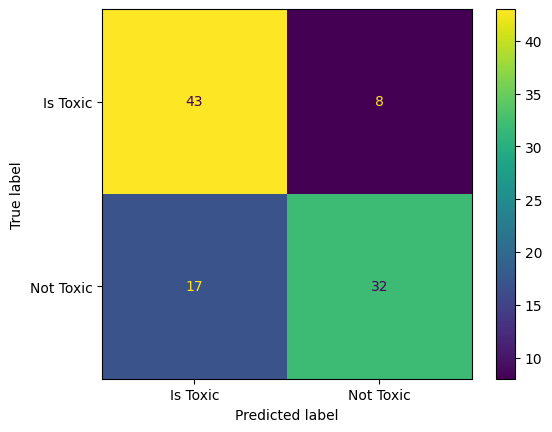

In [31]:
text_test_vect = tfidf_vectorizer.transform(text_test).toarray()

# refit the model with the best hyperparameter value you found
model = RandomForestClassifier(n_estimators=160,min_samples_split=5)
model = model.fit(text_train_vect, is_toxic_train)

# this make predictions for the test set
predictions_test = model.predict(text_test_vect)
print(f"accuracy (on text_test): {accuracy_score(is_toxic_test,predictions_test):.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix(is_toxic_test, predictions_test), display_labels=['Is Toxic', 'Not Toxic'])
disp.plot()